In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
from scipy import ndimage


from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

mpl.rcParams["figure.figsize"] = (15, 15)
# %matplotlib inline

In [2]:
subjFile = "data/anti-slavery-manuscripts-subjects.csv"
subj = pd.read_csv(subjFile)

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]

# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# get beta images
subj_beta = subj.loc[subj["subject_set_id"] == 16228]
len(subj_beta)

60

In [3]:
# read in and do all pre-processing #################################
let_orig, grey_orig = readImg(subj_beta["url"].iloc[10])
grey, let, offset = removeEdges(grey_orig, let_orig, 10.0)

# Get connected components in whole image

In [4]:
def boundsAndRecs(labels, osli, buffer = 0):
    rec = []
    bounds = []
    sh = np.max(labels.shape)
    for sl in osli:
        sl0 = sl[0].indices(sh)
        sl1 = sl[1].indices(sh)

        xLeng = sl1[1]-sl1[0]
        yLeng = sl0[1]-sl0[0]
#         if xLeng*yLeng > 100:
        rec.append([[sl1[0], sl0[0]], xLeng, yLeng])
        bounds.append([(sl0[0]-buffer, sl0[1]+buffer),
                       (sl1[0]-buffer, sl1[1]+buffer)])
    return rec, bounds

In [5]:
def plotCC(labels, rec):
    loop = len(labels)
    fig, ax = plt.subplots(figsize=(27, 18), ncols=loop, nrows=1)
    for i in range(loop):
        if loop > 1:
            axf = ax.flatten()[i]
        else:
            axf = ax
        axf.imshow(labels[i], cmap='nipy_spectral')
        for j in range(len(rec[i])):
            rect = mpl.patches.Rectangle(rec[i][j][0], rec[i][j][1], rec[i][j][2],
                                         linewidth=1, edgecolor="r", facecolor="none")
            axf.add_patch(rect)
    plt.show()

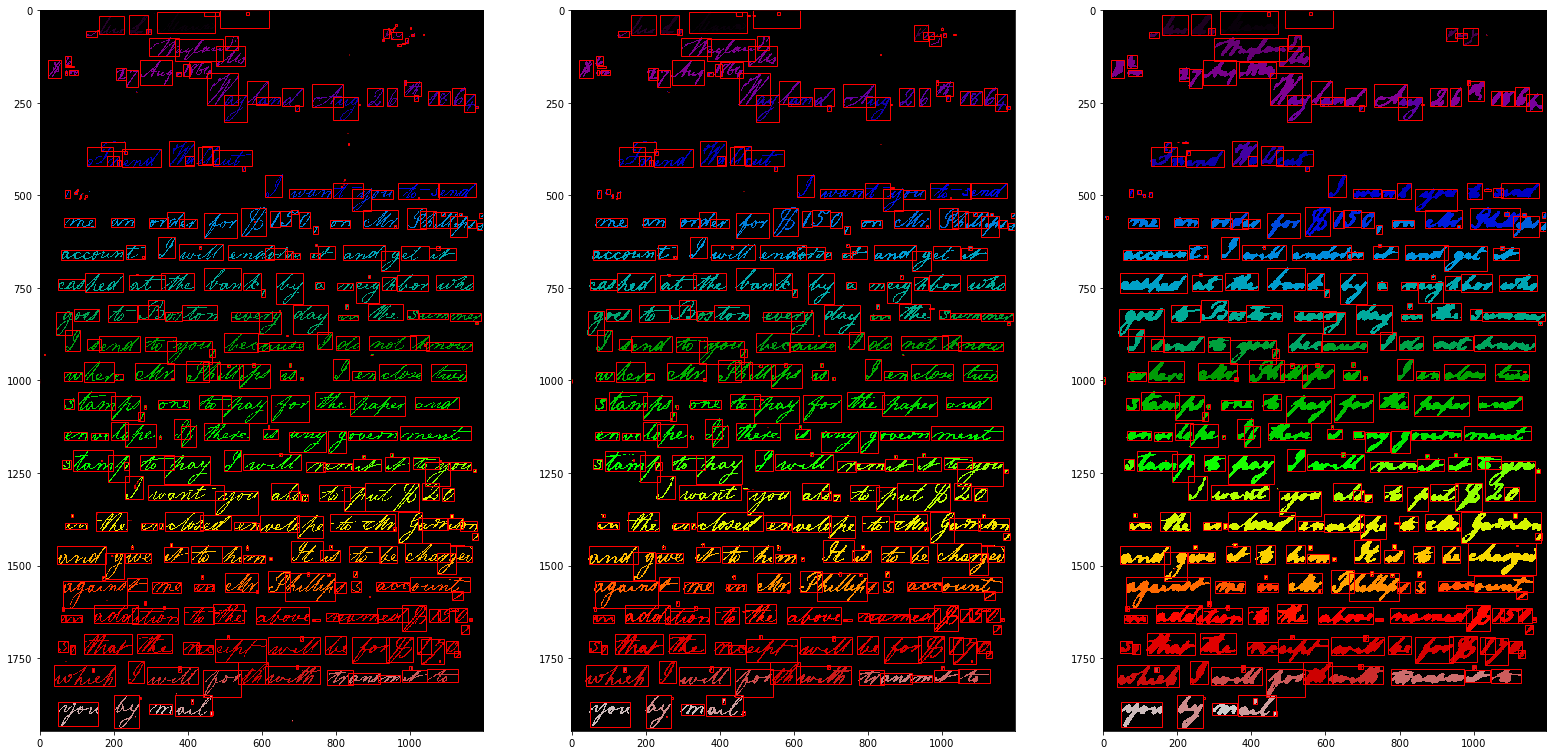

In [6]:
greyBi1, _ = binarizeImg(grey, threshFn=skimfilt.threshold_otsu, greater=False)#, plotIt=True)

labels1, nrObj1 = ndimage.label(greyBi1)
osli1 = ndimage.find_objects(labels1)
rec1, bound1 = boundsAndRecs(labels1, osli1)

greySm2 = smoothImg(grey, 1.0)
greyBi2, _ = binarizeImg(greySm2, threshFn=skimfilt.threshold_otsu, greater=False)#, plotIt=True)

labels2, nrObj2 = ndimage.label(greyBi2)
osli2 = ndimage.find_objects(labels2)
rec2, bound2 = boundsAndRecs(labels2, osli2)

greySm3 = smoothImg(grey, 3.0)
greyBi3, _ = binarizeImg(greySm3, threshFn=skimfilt.threshold_otsu, greater=False)#, plotIt=True)

labels3, nrObj3 = ndimage.label(greyBi3)
osli3 = ndimage.find_objects(labels3)
rec3, bound3 = boundsAndRecs(labels3, osli3)

plotCC([labels1, labels2, labels3], [rec1, rec2, rec3])

# Line breaks

In [7]:
# get linebreaks ####################################################
greySm = smoothImg(grey, 7.0)
matchlim = 30
lb = projBreaks(greySm, "y")
lb = filterBreaks(lb, matchlim)
# plotBoxes(let, lb)#, saveFile="example_img/linebreaks.png")

# Get convex hulls

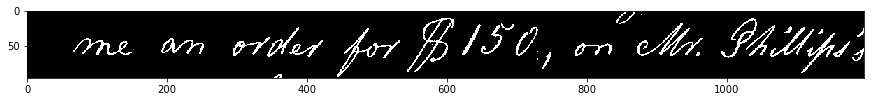

In [8]:
i = 8
chunk = grey[lb[i-1]:lb[i],]
chunkBi, _ = binarizeImg(chunk, threshFn=skimfilt.threshold_otsu, greater=False, plotIt=True)

# References
Convex hull  
Scipy class (not used):
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.spatial.ConvexHull.html  
skimage:
http://scikit-image.org/docs/dev/auto_examples/edges/plot_convex_hull.html  
skimage, find all objects:
http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.convex_hull_object

Center of mass (gravity):
https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.measurements.center_of_mass.html

In [9]:
from skimage.morphology import convex_hull_object
from skimage.morphology import convex_hull_image
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import find_contours
from shapely.geometry import LineString

# from skimage.measure import approximate_polygon

Get labels of image (not used later)

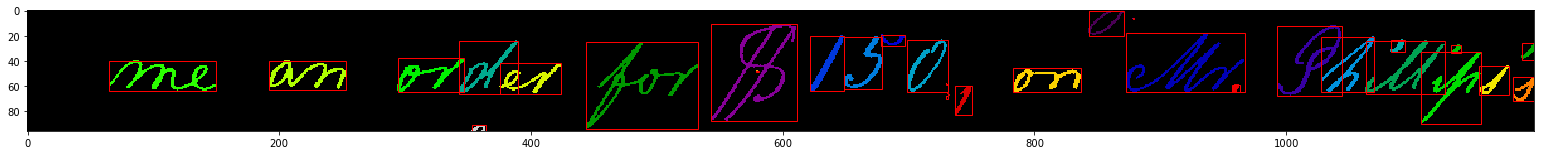

In [10]:
labels, nrObj = ndimage.label(chunkBi)
osli = ndimage.find_objects(labels)
rec, bound = boundsAndRecs(labels, osli)
plotCC([labels], [rec])

Get convex hulls of all connected components (CCs). CCs found automatically

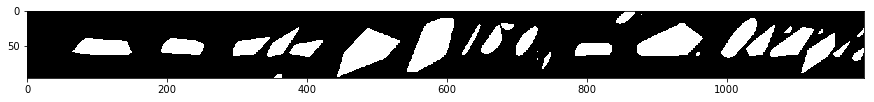

In [11]:
chunk_hull = convex_hull_object(chunkBi, neighbors=4)
nrow, ncol = chunk.shape
plt.imshow(chunk_hull, cmap="gray")
plt.show()

Label convex hulls

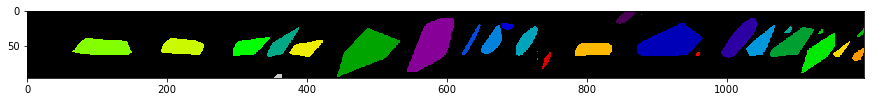

In [12]:
chunk_hull_labels, nrObj = ndimage.label(chunk_hull)

plt.imshow(chunk_hull_labels, cmap="nipy_spectral")
plt.show()

Remove all objects touching the top and bottom that have a center of mass also close to the top or bottom.

In [13]:
edgeThresh = 0.1
centers = center_of_mass(chunk_hull, chunk_hull_labels, range(1, nrObj+1))
thresh_top = nrow*edgeThresh
thresh_bot = nrow - nrow*edgeThresh

# top edge
for j in range(ncol):
    if chunk_hull_labels[0, j] != 0:
        lab = chunk_hull_labels[0, j]
        if centers[lab-1][0] < thresh_top:
            chunk_hull_labels[chunk_hull_labels == lab] = 0
            print("Good riddance, ", lab)

# bottom edge
for j in range(ncol):
    if chunk_hull_labels[nrow-1, j] != 0:
        lab = chunk_hull_labels[nrow-1, j]
        if centers[lab-1][0] > thresh_bot:
            chunk_hull_labels[chunk_hull_labels == lab] = 0
            print("Good riddance, ", lab)

Good riddance,  1
Good riddance,  30


Remove all objects that are just absolutely tiny

In [14]:
sizeThresh = 10
labs = np.unique(chunk_hull_labels)
for lab in labs:
    size = np.sum(chunk_hull_labels == lab)
    if size < sizeThresh:
        chunk_hull_labels[chunk_hull_labels == lab] = 0
        print("Good riddance,", lab, "of size", size)

Good riddance, 2 of size 1
Good riddance, 25 of size 1
Good riddance, 28 of size 1
Good riddance, 29 of size 2


Relabel convex hulls after removing some

In [15]:
chunk_hull = chunk_hull_labels > 0
chunk_hull_labels, nrObj = ndimage.label(chunk_hull)
len(np.unique(chunk_hull_labels))

25

Sort labels by means x values

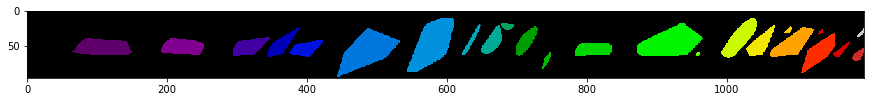

In [16]:
osli = ndimage.find_objects(chunk_hull_labels)
mean_x = [np.mean(x[1].indices(10**10)[:2]) for x in osli]

order = np.argsort(mean_x)
for j in range(len(order)):
    chunk_hull_labels[chunk_hull_labels == order[j]+1] = -(j+1)
chunk_hull_labels *= -1

plt.imshow(chunk_hull_labels, cmap="nipy_spectral")
plt.show()

Get centers of mass for convex hulls

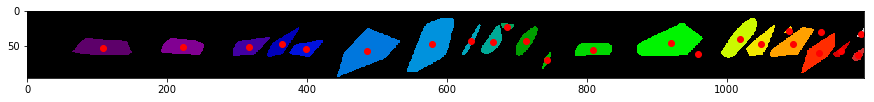

In [17]:
centers = center_of_mass(chunk_hull, chunk_hull_labels, range(1, nrObj+1))

plt.imshow(chunk_hull_labels, cmap="nipy_spectral")
plt.plot([x[1] for x in centers], [y[0] for y in centers], "ro")
plt.show()

Find contours of objects and use these with lines between centers of mass to get distance between objects

In [18]:
contours = find_contours(chunk_hull, 0.5)
contours = [contours[o] for o in order]

In [24]:
distances = []
for j in range(len(contours)-1):
    obj1 = LineString(contours[j])
    obj2 = LineString(contours[j+1])
    center_dist = LineString([centers[j], centers[j+1]])
    
    edge1 = obj1.intersection(center_dist)
    edge2 = obj2.intersection(center_dist)
    distances.append(edge1.distance(edge2))